Load necessary packages

In [6]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from scipy.stats.mstats import mquantiles
from scipy.stats.stats import pearsonr
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.signal import butter, lfilter, filtfilt
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from nitime import algorithms as alg
from nitime import utils
from scipy.stats import t
import xray
import pandas as pd
from rpy2.robjects import FloatVector
from rpy2.robjects.vectors import StrVector
import rpy2.robjects as robjects    
from rpy2.robjects.packages import importr
r = robjects.r

Read precipitation and OLR data

In [7]:
#plt.style.use('ggplot')

#read CMAP precipitation
nc = xray.open_dataset('data/precip.mon.mean.nc')
lat0 = nc['lat']
lon0 = nc['lon']
precip = nc['precip']
nlat=lat0.shape[0]
nlon=lon0.shape[0]
precip_ann=precip[0:335:12,:,:]

#read NOAA OLR
nc = xray.open_dataset('data/olr.mon.mean.nc')
lat1 = nc['lat']
lon1 = nc['lon']
olr0 = nc['olr']
olr0 = olr0*0.01+327.65
olr = olr0[55:390,:,:]
olr_ann = olr0[55:390:12,:,:]

Calculate and test field correlation between cellulose $\delta^{18}O$ and precipitation/OLR

In [8]:
#October-November-December mean
for i in range(precip_ann.shape[0]):
    precip_ann[i,:,:]=np.mean(precip[i*12+9:i*12+11,:,:],axis=0)
    olr_ann[i,:,:]=np.mean(olr[i*12+9:i*12+11,:,:],axis=0)

sst_ann_fil=precip_ann

#load October Kirirom cellulose d18O
data = genfromtxt('data/KRPAM_mon.txt', delimiter=' ')
d18O = data[112:,10]
d18O_median = d18O

#correlation
#sst_ann_new=sst_ann_fil.transpose(1,2,0)
sst_ann_new=sst_ann_fil.transpose("lat","lon","time")
sst_ano=np.ma.anomalies(sst_ann_new,axis=2)
sst_sd=np.sum(sst_ano**2,axis=2)

olr_ann_new=olr_ann.transpose("lat","lon","time")
olr_ano=np.ma.anomalies(olr_ann_new,axis=2)
olr_sd=np.sum(olr_ano**2,axis=2)

d18O_median_ano=np.ma.anomalies(d18O_median)
d18O_median_sd=np.sum(d18O_median_ano**2,axis=0)

pre_nomi_median=np.dot(sst_ano,d18O_median_ano)
olr_nomi_median=np.dot(olr_ano,d18O_median_ano)

corr_pre = pre_nomi_median/np.sqrt(np.dot(sst_sd[:,:,None],d18O_median_sd[None]))
corr_olr = olr_nomi_median/np.sqrt(np.dot(olr_sd[:,:,None],d18O_median_sd[None]))

In [9]:
#t-test for correlation
d18O_coef, d18O_sigma = alg.AR_est_YW(d18O_median_ano,1)
neff_array=sst_ano[:,:,0]
latt,lont=[],[]
lat_normal,lon_normal=[],[]
pval_pre=[]
pval_olr=[]

for ilat in range(nlat):
    for ilon in range(nlon):
        if np.isnan(sst_ano[ilat,ilon,0])==False:
            coef_pre, sigma_pre = alg.AR_est_YW(sst_ano[ilat,ilon,:],1)
            coef_olr, sigma_olr = alg.AR_est_YW(olr_ano[ilat,ilon,:],1)
#            sst_coef[ilat,ilon] = coef
            neff_pre=28*(1-d18O_coef*coef_pre)/(1+d18O_coef*coef_pre)
            neff_olr=28*(1-d18O_coef*coef_olr)/(1+d18O_coef*coef_olr)
            latt.append(lat0[ilat])
            lont.append(lon0[ilon])

            tval_pre=corr_pre[ilat,ilon]/np.sqrt(1-corr_pre[ilat,ilon]**2)*np.sqrt(neff_pre-2)
            tval_olr=corr_olr[ilat,ilon]/np.sqrt(1-corr_olr[ilat,ilon]**2)*np.sqrt(neff_olr-2)

            pval0_pre=t.sf(abs(tval_pre),neff_pre-2)*2
            pval0_olr=t.sf(abs(tval_olr),neff_olr-2)*2
            pval_pre.append(pval0_pre)
            pval_olr.append(pval0_olr)
#            if pval0 < 0.1:
#                lat_normal.append(lat0[ilat])
#                lon_normal.append(lon0[ilon])

pvalr_pre = FloatVector(pval_pre)
pvalr_olr = FloatVector(pval_olr)

r.source("fdr.R")
#sig_med = r.fdr(pvalr_med,method="original",adjustment_method="mean")

sig_pre = r.fdr(pvalr_pre,method="original",qlevel=0.1)
sig_olr = r.fdr(pvalr_olr,method="original",qlevel=0.1)

print(sig_pre)
#print(sig_975)
lat_pre=latt[:]
lon_pre=lont[:]
lat_olr=latt[:]
lon_olr=lont[:]
#lat975=[]
#lon975=[]
if sig_pre:
    for isig in sorted(sig_pre,reverse=True):
         del lat_pre[isig-1]
         del lon_pre[isig-1]
#        lat975.append(latt[isig-1])
#        lon975.append(lont[isig-1])
if sig_olr:
    for isig in sorted(sig_olr,reverse=True):
         del lat_olr[isig-1]
         del lon_olr[isig-1]

NULL


Plot field correlations

/Users/hujun/anaconda/envs/snakes/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


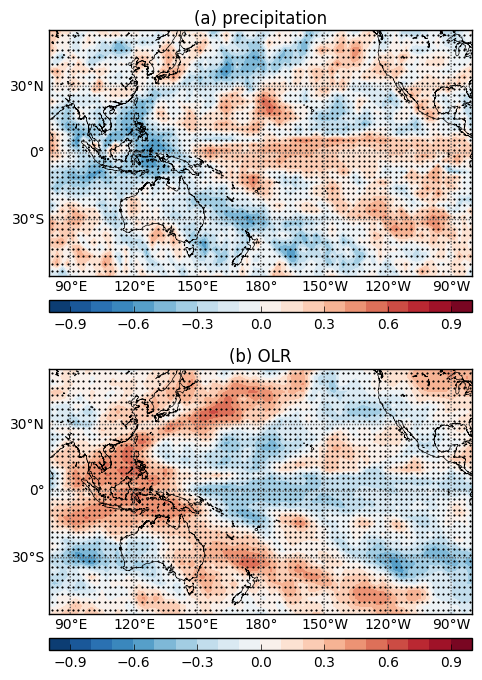

In [10]:
#plot figures
map = Basemap(projection='merc',resolution='l',lat_0=0,lon_0=180,llcrnrlon=80,llcrnrlat=-50,urcrnrlon=280,urcrnrlat=50)

lons, lats = np.meshgrid(lon0, lat0)
x,y=map(lons,lats)
fig=plt.figure(figsize=(10,8))
ax1=fig.add_subplot(211)
map.drawcoastlines(linewidth=0.5,color='k')
#map.fillcontinents(color='gray')
#map.drawmapboundary()
map.drawmeridians(np.arange(0,360,30),color='DimGray',labels=[1,0,0,1],fontsize=10)
map.drawparallels(np.arange(-90,90,30),color='DimGray',labels=[1,0,0,1],fontsize=10)
clevs=np.linspace(-1,1,21)
cs=map.contourf(x,y,corr_pre,clevs,cmap=plt.cm.RdBu_r)
cbar = map.colorbar(cs,location='bottom',pad="10%")
cbar.ax.tick_params(labelsize=10)
x2,y2=map(lon_pre,lat_pre)
passt=map.plot(x2,y2,'ko',markersize=1)
ax1.set_title("(a) precipitation",fontsize=12)

lons1, lats1 = np.meshgrid(lon1, lat1)
x1,y1=map(lons1,lats1)
ax2=fig.add_subplot(212)
map.drawcoastlines(linewidth=0.5,color='k')
#map.fillcontinents(color='gray')
#map.drawmapboundary()
map.drawmeridians(np.arange(0,360,30),color='DimGray',labels=[1,0,0,1],fontsize=10)
map.drawparallels(np.arange(-90,90,30),color='DimGray',labels=[1,0,0,1],fontsize=10)
clevs=np.linspace(-1,1,21)
cs=map.contourf(x1,y1,corr_olr,clevs,cmap=plt.cm.RdBu_r)
cbar = map.colorbar(cs,location='bottom',pad="10%")
cbar.ax.tick_params(labelsize=10)
x2,y2=map(lon_olr,lat_olr)
passt=map.plot(x2,y2,'ko',markersize=1)
ax2.set_title("(b) OLR",fontsize=12)